# Annual Messages to Congress on the State of the Union
Wikipedia:
The State of the Union Address (sometimes abbreviated to SOTU) is an annual message delivered by the president of the United States to the U.S. Congress near the beginning of each calendar year on the current condition of the nation. The message typically includes reports on the nation's budget, economy, news, agenda, achievements and the president's priorities and legislative proposals.

## Load Data

Set the path of stored data into `PATH`, if you dont have any data, run `Download.ipynb`

In [1]:
# import libraries
import csv
import warnings
warnings.filterwarnings("ignore")

In [2]:
PATH = 'SOTU_data' # path of stored data

Save Metadata into dicts/list/dataframes 

In [3]:
file_date = {} # a dict to store file_name : date map
file_president = {} # a dict to store file_name: president_name
date_list = []
# open metadata information 
with open(PATH + '/information.csv', 'r') as c:
    csv_reader = csv.reader(c)
    header = next(csv_reader)
    if header != None:
        for row in csv_reader:
            # save to file_date dict 
            file_date[row[0]] = row[2]
            date_list.append(row[2].split(', ')[-1])
            
            # save to file_president dict
            file_president[row[0]] = row[4]

Open stored txt files and save into a dict

In [4]:
file_document = {} # a dict to store file_name : document text map
president_document = {} # a dict to store president_name: concatenation of documents text 

corpus :str = "" # a corpus of all texts


# building key and type of president_document dict
for president_name in set(file_president.values()):
    president_document[president_name] = ""

# store each content
for file_name in file_date.keys():
    with open(PATH + '/speaches/' + file_name) as f:
        content = ' '.join(f.read().splitlines())
    file_document[file_name] = content
    president_document[file_president[file_name]] = president_document[file_president[file_name]] + content
    corpus = corpus + content

a text sample (1000 first characters) from `0.txt` file:

In [5]:
doc_sample = file_document['0.txt'][0:1000]
doc_sample 

' To the Congress: In considering the State of the Union, the war and the peace that is to follow are naturally uppermost in the minds of all of us. This war must be waged—it is being waged—with the greatest and most persistent intensity. Everything we are and have is at stake. Everything we are and have will be given. American men, fighting far from home, have already won victories which the world will never forget. We have no question of the ultimate victory. We have no question of the cost. Our losses will be heavy. We and our allies will go on fighting together to ultimate total victory. We have seen a year marked, on the whole, by substantial progress toward victory, even though the year ended with a setback for our arms, when the Germans launched a ferocious counter-attack into Luxembourg and Belgium with the obvious objective of cutting our line in the center. Our men have fought with indescribable and unforgettable gallantry under most difficult conditions, and our German enemi

a text sample (1000 first characters) from Donald J. Trump:

In [6]:
president_sample = president_document['Donald J. Trump'][0:1000]
president_sample

" The President. Mr. Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States, and my fellow Americans: Less than 1 year has passed since I first stood at this podium, in this majestic Chamber, to speak on behalf of the American people and to address their concerns, their hopes, and their dreams. That night, our new administration had already taken very swift action. A new tide of optimism was already sweeping across our land. Each day since, we have gone forward with a clear vision and a righteous mission: to make America great again for all Americans. Over the last year, we have made incredible progress and achieved extraordinary success. We have faced challenges we expected and others we could never have imagined. We have shared in the heights of victory and the pains of hardship. We have endured floods and fires and storms. But through it all, we have seen the beauty of America's soul and the steel in America's spine. Each test has forged new American h

## Per-process Data

In [7]:
# import libraries
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import regexp_tokenize

In [8]:
# Tokenzier
text_sample_token = ''

# http://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)
# how to use
sample_tokenized = regexp_tokenize(text_sample_token, pattern)

In [9]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def pre_process(text, lemmatize=True, stop=True):
    # remove [Laughter] and [Applause]
    text = re.sub(r'(:?\[Laughter\]|\[Applause\])', '', text)
    text = text.lower()
    # remove non letters: (e.g, punctuations): [^a-zA-Z0-9_]
    # remove digit+ word+: 2nd
    # remove digit+ : 22
    # remove digit+ word+ digit+: 2nd2
    text = re.sub(r'[^a-zA-Z0-9_]|\b\d+\w*\d*\b', ' ', text)    
    if stop:
        # filter stopwords
        text = " ".join([word for word in regexp_tokenize(text, pattern) if word not in stop_words])
    if lemmatize:
        # lemmatize words: Returns the input word unchanged if it cannot be found in WordNet.
        text = " ".join([lemmatizer.lemmatize(word) for word in regexp_tokenize(text, pattern)])
    return text

Apply `pre_process` function on data: unexpectedly fast

In [10]:
file_normlized_doc = {}
president_normlized_doc = {}
normlized_doc = []

for key in file_document.keys():
    n_doc = pre_process(file_document[key])
    file_normlized_doc[key] = n_doc
    normlized_doc.append(n_doc)
    
for key in president_document.keys():
    n_doc = pre_process(president_document[key])
    president_normlized_doc[key] = n_doc

## Process Data

In [26]:
# import libraries
import re
import numpy as np
import pandas as pd
import itertools
from nltk import FreqDist
from nltk.tokenize import sent_tokenize
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pyLDAvis.sklearn, pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

### Freq Analysis

In [12]:
president_tokenized_doc = {}

for president in president_normlized_doc.keys():
    president_tokenized_doc[president] = regexp_tokenize(president_normlized_doc[president], pattern)
    
president_dataframe = {}

for opt in president_tokenized_doc.keys():
     president_dataframe[opt] = FreqDist(president_tokenized_doc[opt]).most_common(50)

freq_analysis = pd.DataFrame(president_dataframe)
freq_analysis

,George Bush,Jimmy Carter,Dwight D. Eisenhower,Richard Nixon,John F. Kennedy,William J. Clinton,Gerald R. Ford,Barack Obama,Ronald Reagan,Lyndon B. Johnson,Donald J. Trump,George W. Bush,Harry S. Truman,Franklin D. Roosevelt
0,"(world, 77)","(year, 804)","(nation, 255)","(year, 598)","(nation, 93)","(year, 380)","(year, 95)","(american, 285)","(year, 187)","(year, 201)","(american, 164)","(america, 222)","(world, 261)","(war, 76)"
1,"(american, 72)","(program, 626)","(must, 252)","(new, 443)","(new, 79)","(american, 305)","(federal, 65)","(year, 282)","(america, 176)","(must, 147)","(year, 103)","(american, 179)","(nation, 198)","(must, 42)"
2,"(america, 61)","(congress, 522)","(year, 248)","(program, 421)","(year, 74)","(people, 299)","(american, 61)","(job, 236)","(u, 160)","(nation, 145)","(america, 93)","(people, 158)","(must, 181)","(peace, 34)"
3,"(u, 61)","(administration, 443)","(program, 228)","(federal, 404)","(world, 72)","(must, 273)","(state, 60)","(america, 225)","(american, 151)","(american, 132)","(thank, 82)","(must, 150)","(people, 161)","(force, 33)"
4,"(must, 56)","(nation, 439)","(government, 217)","(congress, 333)","(must, 52)","(child, 251)","(new, 60)","(new, 197)","(people, 133)","(congress, 119)","(u, 75)","(year, 143)","(free, 159)","(people, 27)"
5,"(people, 52)","(government, 391)","(world, 210)","(government, 332)","(u, 48)","(new, 232)","(world, 57)","(people, 183)","(government, 131)","(people, 109)","(new, 67)","(nation, 132)","(year, 157)","(army, 26)"
6,"(know, 50)","(new, 387)","(people, 189)","(state, 307)","(free, 47)","(america, 230)","(program, 57)","(u, 177)","(must, 126)","(new, 94)","(one, 67)","(u, 128)","(war, 118)","(men, 23)"
7,"(time, 45)","(federal, 386)","(federal, 173)","(american, 289)","(program, 46)","(work, 215)","(congress, 56)","(work, 161)","(freedom, 94)","(u, 83)","(people, 65)","(world, 124)","(congress, 113)","(year, 23)"
8,"(new, 44)","(state, 379)","(state, 160)","(also, 282)","(effort, 42)","(u, 194)","(must, 55)","(make, 156)","(let, 89)","(program, 77)","(country, 64)","(country, 113)","(economic, 110)","(nation, 22)"
9,"(one, 43)","(energy, 331)","(congress, 157)","(people, 255)","(congress, 40)","(every, 184)","(energy, 55)","(let, 135)","(world, 88)","(world, 74)","(tonight, 60)","(new, 108)","(great, 108)","(need, 22)"


### Key Phrases

In [13]:
corpus_normlized = pre_process(corpus, lemmatize=False, stop=False)
sentences = sent_tokenize(corpus_normlized)
sentence_stream = [regexp_tokenize(sent, pattern) for sent in sentences]
phrase_model = Phrases(sentence_stream, min_count=100, threshold=2, connector_words=ENGLISH_CONNECTOR_WORDS)
print(phrase_model['thank', 'you', 'state', 'of' , 'the', 'union', 'vice', 'president', 'mr', 'speaker'])

['thank_you', 'state_of_the_union', 'vice', 'president', 'mr', 'speaker']


In [14]:
phrase_dict_underline = {}
for key in phrase_model.vocab.keys():
    if '_' in key:
        value =  phrase_model.vocab[key]
        if int(value) > 100:
            list_key = key.split('_')
            len_key = len(list_key)
            list_key_exstop = [word for word in list_key if word not in stop_words]
            len_key_exstop = len(list_key_exstop)
            
            if len_key_exstop > 1:
                phrase_dict_underline[key] = value
            
            
        
len(phrase_dict_underline)

21

In [15]:
phrase_dict_underline

{'state_of_the_union': 113,
 'soviet_union': 170,
 'last_year': 421,
 'men_and_women': 133,
 'united_nations': 130,
 'american_people': 291,
 'united_states': 604,
 'every_american': 105,
 'let_us': 201,
 'social_security': 190,
 'federal_government': 283,
 'state_and_local': 178,
 'local_governments': 114,
 'fiscal_year': 112,
 'years_ago': 208,
 'human_rights': 109,
 'middle_east': 128,
 'economic_growth': 106,
 'first_time': 129,
 'free_world': 112,
 'health_care': 220}

### LDA 
LDA is a generative statistical model for topic modeling. LDA is based on term counts and document counts. 

- `ngram_range`=(1,2), means the lower bound is 1 and upper boundary is 2 from the range of values for different word n-grams.
- `min_df`= 4, removes words with occurrence in less than 4 documents.
- `max_df` = 0.6, ignores the terms that have a document frequency strictly higher than 0.6.
- `max_features`=1000, selects 1000 top features by the score of term frequencey.
- `n_components` = 3, chooses number of topics=3

In [16]:
number_of_topics = 3 #number of topics

In [17]:
# a function to compute count vectorizer and LDA
def lda_costum(docs, n_topics=3):
    c_vectorizer_model = CountVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=pattern , max_df=0.6, min_df=5, max_features=1000)
    cv_fit = c_vectorizer_model.fit_transform(docs)
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=100, n_jobs=-1)
    lda_model.fit(cv_fit)
    return lda_model, cv_fit, c_vectorizer_model
    
# a function to give words of each topic for LDA: number_show can be cahnged
def lda_display(lda_model, c_vectorizer_model):
    names = c_vectorizer_model.get_feature_names()
    number_show = 10
    for ind, topic in enumerate(lda_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")

# a function to plot the topics during the time
def costum_plot(model, model_fit, n_words = 30):
    
    time_series = []
    n_words = 30
    for index in range(number_of_topics):
        top_number_indices = np.argsort(model.components_ * -1)[index,:n_words]
        values = model_fit[:,top_number_indices].transpose().sum(axis=0)
        time_series.append(values)
        
    concatenate_values = np.concatenate(tuple(time_series))
    normlized_values = normalize(concatenate_values, norm='l1', axis=0)
    
    index_list = [f'Topic {ind}' for ind in range(number_of_topics)]
    df = pd.DataFrame(data=normlized_values.T, index=date_list, columns=index_list)

    plot = sns.lineplot(data=df)
    plt.setp(plot.get_xticklabels(), rotation=90)

Apply `lda_costum` function to compute topics and display the top 10 words in each topic using `lda_display` function.

In [18]:
lda_model, cv_fit, c_vectorizer_model = lda_costum(normlized_doc, n_topics=number_of_topics)
lda_display(lda_model, c_vectorizer_model)

Topic 0: ['shall', 'communist', 'labor', 'free world', 'recommend', 'expenditure', 'united nation', 'aggression', 'whole', 'recommendation']
Topic 1: ['proposed', 'agency', 'oil', 'employment', 'rural', 'state local', 'management', 'transportation', 'comprehensive', 'ensure']
Topic 2: ['tonight', 'thank', 'drug', 'terrorist', 'parent', 'pas', 'health care', 'college', 'iraq', 'student']


Apply `costum_plot` function to see how much each topic is spoken during the time, we consider top 30 words from each topic

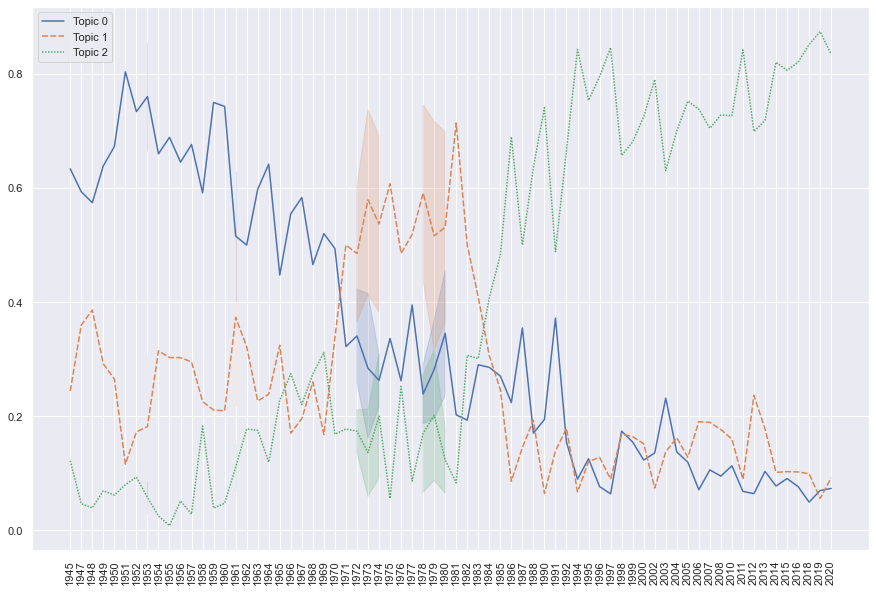

In [27]:
costum_plot(lda_model, cv_fit, 30)

Use `pyLDAvis` to plot Intertopic Distance Map of Topics and Top-30 Most Relevant Terms for each topic 

In [20]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, cv_fit, c_vectorizer_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.090012  0.068038       1        1  40.647509
2      0.136109  0.016398       2        1  32.171644
0     -0.046097 -0.084436       3        1  27.180848, topic_info=          Term        Freq       Total Category  logprob  loglift
909    tonight  517.000000  517.000000  Default  30.0000  30.0000
798      shall  314.000000  314.000000  Default  29.0000  29.0000
893      thank  216.000000  216.000000  Default  28.0000  28.0000
145  communist  168.000000  168.000000  Default  27.0000  27.0000
891  terrorist  155.000000  155.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
107      carry   60.212819  116.254654   Topic3  -5.8383   0.6448
807       side   59.337807  115.617091   Topic3  -5.8529   0.6356
313  executive   65.484592  182.999985   Topic3  -5.7544   0.2750
682    propose   70.967480  264.418477   Topic3  -5.6740  -0.0127
382    general   61.416331  159.494136   Topic3  -5.8185   0.3483

[192 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
9         1  0.752099     activity
9         2  0.030824     activity
9         3  0.221931     activity
13        1  0.843275     addition
13        2  0.006969     addition
...     ...       ...          ...
990       1  0.234712  world peace
990       3  0.743256  world peace
991       1  0.216693    world war
991       2  0.159669    world war
991       3  0.627270    world war

[411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### NMF 
Non Matrix Factorization using Tf-idf
- `ngram_range`=(1,3), means the lower bound is 1 and upper boundary is 3 from the range of values for different word n-grams.
- `min_df`= 4, removes words with occurrence in less than 4 documents.
- `max_df` = 0.6, ignores the terms that have a document frequency strictly higher than 0.6.
- `max_features`=5000, selects 5000 top features by the score of term frequencey.
- `n_components` = 3, chooses number of topics=3

In [21]:
number_of_topics = 3 #number of topics

In [22]:
# a function to compute TFIDF and NMF
def nmf_costum(docs, n_topics=4):
    tf_vectorizer_model = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=pattern, max_df=0.6, min_df=5, max_features=5000)
    tf_fit = tf_vectorizer_model.fit_transform(docs)
    nmf_model = NMF(n_components=n_topics, init='nndsvd', alpha=0.1, l1_ratio=0.1, random_state=100).fit(tf_fit)

    return nmf_model, tf_fit, tf_vectorizer_model
    
# a function to give words of each topic for NMF: number_show can be cahnged
def nmf_display(nmf_model, tf_vectorizer_model):
    names = tf_vectorizer_model.get_feature_names()
    number_show = 10
    for ind, topic in enumerate(nmf_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")
        

Apply `nmf_costum` function to compute topics and display the top 10 words in each topic using `nmf_display` function.

In [23]:
nmf_model, tf_fit, tf_vectorizer_model = nmf_costum(normlized_doc, n_topics=number_of_topics)
nmf_display(nmf_model, tf_vectorizer_model)

Topic 0: ['shall', 'communist', 'labor', 'free world', 'recommend', 'expenditure', 'free nation', 'recommendation', 'aggression', 'united nation']
Topic 1: ['tonight', 'thank', 'terrorist', 'iraq', 'parent', 'college', 'pas', 'kid', 'company', 'drug']
Topic 2: ['oil', 'environmental', 'proposed', 'rural', 'state local', 'transportation', 'agency', 'employment', 'regulatory', 'local government']


Apply `costum_plot` function to see how much each topic is spoken during the time, we consider top 30 words from each topic

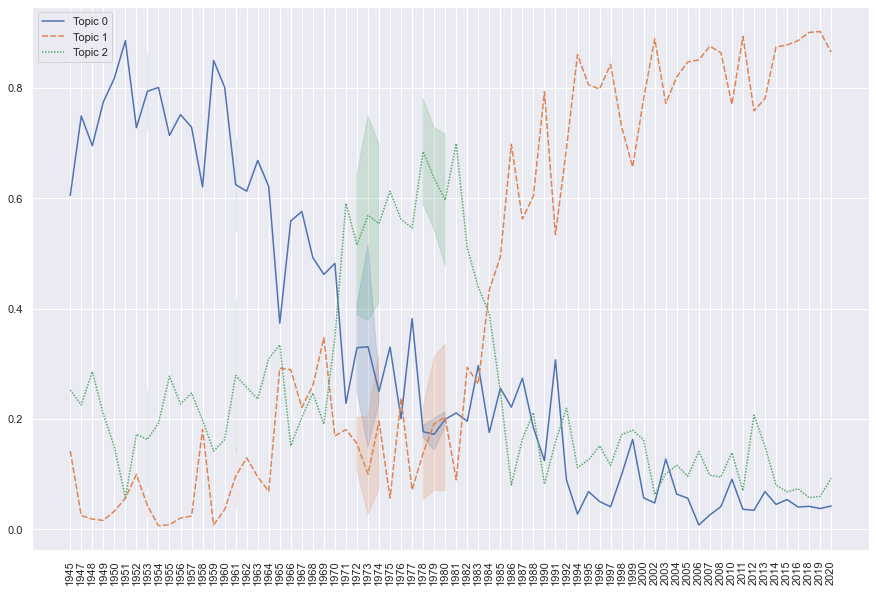

In [28]:
costum_plot(nmf_model, tf_fit, 30)

Use `pyLDAvis` to plot Intertopic Distance Map of Topics and Top-30 Most Relevant Terms for each topic 

In [25]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(nmf_model, tf_fit, tf_vectorizer_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.224155  0.039830       1        1  40.217144
0     -0.066778 -0.167735       2        1  34.676735
2     -0.157377  0.127904       3        1  25.106121, topic_info=            Term      Freq     Total Category  logprob  loglift
3989       shall  4.000000  4.000000  Default  30.0000  30.0000
4477     tonight  6.000000  6.000000  Default  29.0000  29.0000
748    communist  2.000000  2.000000  Default  28.0000  28.0000
4408       thank  2.000000  2.000000  Default  27.0000  27.0000
4402   terrorist  2.000000  2.000000  Default  26.0000  26.0000
...          ...       ...       ...      ...      ...      ...
2542  management  1.004490  2.111735   Topic3  -6.2223   0.6390
2823     natural  0.897345  1.603513   Topic3  -6.3351   0.8015
3439     propose  0.964409  2.641328   Topic3  -6.2631   0.3745
48      activity  0.902867  1.795209   Topic3  -6.3290   0.6948
735   commission  0.880237  1.899217   Topic3  -6.3544   0.6131

[279 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        3  1.069537     abuse
48        2  0.557038  activity
48        3  0.557038  activity
57        3  0.743794  addition
63        2  0.665257  adequate
...     ...       ...       ...
4661      3  0.680852     urban
4707      1  0.549637   vietnam
4707      2  0.549637   vietnam
4719      1  1.735676   violent
4809      2  0.723430     whole

[171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])